<a href="https://colab.research.google.com/github/vinayykkumar/Visionary-Advanced-Image-Recognition-for-the-Next-Era_Infosys_Internship_Oct2024/blob/durga_prasad/Face_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
import os
import cv2
import numpy as np
from PIL import Image, ImageEnhance, ImageOps
import random


def augment_image(image):
    """
    Apply random augmentations to an image using Pillow.
    """
    # Random rotation
    if random.random() > 0.5:
        angle = random.uniform(-30, 30)  # Rotate between -30 and 30 degrees
        image = image.rotate(angle, expand=True)

    # Random horizontal flip
    if random.random() > 0.5:
        image = ImageOps.mirror(image)

    # Random brightness adjustment
    if random.random() > 0.5:
        enhancer = ImageEnhance.Brightness(image)
        factor = random.uniform(0.8, 1.2)  # Brightness factor
        image = enhancer.enhance(factor)

    # Random zoom (crop and resize back)
    if random.random() > 0.5:
        width, height = image.size
        zoom_factor = random.uniform(0.8, 1.2)  # Zoom in/out factor
        new_width = int(width * zoom_factor)
        new_height = int(height * zoom_factor)
        image = image.resize((new_width, new_height), Image.Resampling.LANCZOS)  # Use Resampling.LANCZOS
        if zoom_factor > 1:
            # Crop to original size
            left = (new_width - width) // 2
            top = (new_height - height) // 2
            image = image.crop((left, top, left + width, top + height))
        else:
            # Pad to original size
            image = ImageOps.pad(image, (width, height), color=(0, 0, 0))

    return image

In [5]:
def preprocess_and_augment_with_pillow(input_dir, output_dir, img_size=(128, 128), augmentations=4):
    """
    Preprocesses and augments images using OpenCV and Pillow.

    Args:
        input_dir (str): Path to the input dataset directory.
        output_dir (str): Path to the output directory for preprocessed and augmented images.
        img_size (tuple): Target size for resizing the images (width, height).
        augmentations (int): Number of augmented images to generate per input image.
    """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Iterate through each person's folder in the dataset
    for person_name in os.listdir(input_dir):
        person_folder = os.path.join(input_dir, person_name)
        output_person_folder = os.path.join(output_dir, person_name)

        if not os.path.isdir(person_folder):
            continue  # Skip files, only process directories

        # Create corresponding output directory for each person if it doesn't exist
        if not os.path.exists(output_person_folder):
            os.makedirs(output_person_folder)

        # Process each image in the person's folder
        for img_name in os.listdir(person_folder):
            img_path = os.path.join(person_folder, img_name)

            # Read the image using OpenCV
            image = cv2.imread(img_path)
            if image is None:
                print(f"Warning: Could not read image {img_path}")
                continue

            # Step 1: Resize the image
            image_resized = cv2.resize(image, img_size)

            # Step 2: Apply Bilateral Filter for noise reduction while preserving edges
            image_bilateral = cv2.bilateralFilter(image_resized, d=9, sigmaColor=75, sigmaSpace=75)

            # Step 3: Convert to grayscale for thresholding
            gray = cv2.cvtColor(image_bilateral, cv2.COLOR_BGR2GRAY)

            # Step 4: Apply simple thresholding for background removal
            _, thresholded = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV)

            # Apply the threshold mask to the original image
            foreground = cv2.bitwise_and(image_bilateral, image_bilateral, mask=thresholded)

            # Save the preprocessed image
            preprocessed_path = os.path.join(output_person_folder, f"processed_{img_name}")
            cv2.imwrite(preprocessed_path, foreground)
            print(f"Preprocessed and saved: {preprocessed_path}")

            # Convert to Pillow Image for augmentation
            pil_image = Image.fromarray(cv2.cvtColor(foreground, cv2.COLOR_BGR2RGB))

            # Step 5: Apply data augmentation with Pillow
            for i in range(augmentations):
                augmented_image = augment_image(pil_image)  # Apply random augmentations
                aug_img_path = os.path.join(output_person_folder, f"aug_{i}_{img_name}")
                augmented_image.save(aug_img_path)
                print(f"Augmented and saved: {aug_img_path}")
# Define input and output directories
input_directory = "//content//gdrive//MyDrive//My dataset"          # Replace with the path to your dataset folder
output_directory = "augmented_dataset"           # Where augmented images will be saved

# Call the preprocessing and augmentation function
preprocess_and_augment_with_pillow(input_directory, output_directory)

Streaming output truncated to the last 5000 lines.
Preprocessed and saved: augmented_dataset/Akshay Kumar/processed_81941727_10157464655128283_2264285176240537600_n.jpg
Augmented and saved: augmented_dataset/Akshay Kumar/aug_0_81941727_10157464655128283_2264285176240537600_n.jpg
Augmented and saved: augmented_dataset/Akshay Kumar/aug_1_81941727_10157464655128283_2264285176240537600_n.jpg
Augmented and saved: augmented_dataset/Akshay Kumar/aug_2_81941727_10157464655128283_2264285176240537600_n.jpg
Augmented and saved: augmented_dataset/Akshay Kumar/aug_3_81941727_10157464655128283_2264285176240537600_n.jpg
Preprocessed and saved: augmented_dataset/Akshay Kumar/processed_87.jpg
Augmented and saved: augmented_dataset/Akshay Kumar/aug_0_87.jpg
Augmented and saved: augmented_dataset/Akshay Kumar/aug_1_87.jpg
Augmented and saved: augmented_dataset/Akshay Kumar/aug_2_87.jpg
Augmented and saved: augmented_dataset/Akshay Kumar/aug_3_87.jpg
Preprocessed and saved: augmented_dataset/Akshay Kumar/

In [12]:
import os

def count_images_in_directory(directory):
    """
    Counts the number of image files in a directory (including subdirectories).

    Args:
        directory (str): Path to the directory to count images in.

    Returns:
        int: The total number of image files.
    """
    count = 0
    for root, _, files in os.walk(directory):
        count += len([file for file in files if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))])
    return count

# Define input and output directories
input_directory = "//content//gdrive//MyDrive//My dataset"  # Replace with the path to your dataset folder
output_directory = "augmented_dataset"                      # Replace with the path to your augmented dataset folder

# Count the images before and after augmentation
num_images_before = count_images_in_directory(input_directory)
num_images_after = count_images_in_directory(output_directory)

print(f"Number of images before augmentation: {num_images_before}")
print(f"Number of images after augmentation: {num_images_after}")


Number of images before augmentation: 1168
Number of images after augmentation: 5840


In [6]:
import os
import numpy as np
import cv2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
def load_dataset(dataset_dir, img_size=(128, 128)):
    """
    Load images and labels from the specified dataset directory.

    Args:
        dataset_dir (str): Path to dataset directory.
        img_size (tuple): Target size for resizing images.

    Returns:
        tuple: Tuple containing image data (X), labels (y), and LabelEncoder instance.
    """
    X, y = [], []
    label_names = []

    for person_name in os.listdir(dataset_dir):
        person_folder = os.path.join(dataset_dir, person_name)
        if not os.path.isdir(person_folder):
            continue

        label_names.append(person_name)
        for img_name in os.listdir(person_folder):
            img_path = os.path.join(person_folder, img_name)
            img = cv2.imread(img_path)
            if img is None:
                continue
            img = cv2.resize(img, img_size)
            X.append(img)
            y.append(person_name)

    X = np.array(X, dtype='float32') / 255.0  # Normalize images
    y = np.array(y)

    # Encode labels to integers
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(y)

    return X, y, label_encoder

In [8]:
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

def build_improved_model(input_shape, num_classes, learning_rate=0.001, weight_decay=1e-4):
    """
    Build and compile an improved CNN model with Batch Normalization and L2 regularization.

    Args:
        input_shape (tuple): Shape of the input images.
        num_classes (int): Number of output classes.
        learning_rate (float): Learning rate for the optimizer.
        weight_decay (float): Weight decay (L2 regularization factor).

    Returns:
        model: Compiled CNN model.
    """
    model = Sequential([
        # First Convolutional Block
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape,
               kernel_regularizer=regularizers.l2(weight_decay)),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        # Second Convolutional Block
        Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(weight_decay)),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        # Third Convolutional Block
        Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(weight_decay)),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        # Fourth Convolutional Block
        Conv2D(256, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(weight_decay)),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        # Global Average Pooling and Dense Layers
        GlobalAveragePooling2D(),
        Dense(128, activation='relu', kernel_regularizer=regularizers.l2(weight_decay)),
        Dropout(0.5),
        Dense(num_classes, activation='softmax', kernel_regularizer=regularizers.l2(weight_decay))
    ])

    # Compile the model
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

In [9]:
def plot_training_history(history):
    """
    Plot training and validation accuracy and loss.

    Args:
        history: Training history object from Keras model.
    """
    # Accuracy Plot
    plt.figure(figsize=(12, 6))
    sns.lineplot(x=range(1, len(history.history['accuracy']) + 1), y=history.history['accuracy'], label='Training Accuracy', color='blue')
    sns.lineplot(x=range(1, len(history.history['val_accuracy']) + 1), y=history.history['val_accuracy'], label='Validation Accuracy', color='red')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # Loss Plot
    plt.figure(figsize=(12, 6))
    sns.lineplot(x=range(1, len(history.history['loss']) + 1), y=history.history['loss'], label='Training Loss', color='blue')
    sns.lineplot(x=range(1, len(history.history['val_loss']) + 1), y=history.history['val_loss'], label='Validation Loss', color='red')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 303s 2s/step - accuracy: 0.3434 - loss: 1.5634 - val_accuracy: 0.2920 - val_loss: 1.6210
Epoch 2/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 324s 2s/step - accuracy: 0.4590 - loss: 1.2703 - val_accuracy: 0.2637 - val_loss: 1.7573
Epoch 3/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 326s 2s/step - accuracy: 0.5117 - loss: 1.1580 - val_accuracy: 0.5616 - val_loss: 1.1044
Epoch 4/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 315s 2s/step - accuracy: 0.5554 - loss: 1.0839 - val_accuracy: 0.6113 - val_loss: 0.9921
Epoch 5/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 308s 2s/step - accuracy: 0.6215 - loss: 0.9965 - val_accuracy: 0.6241 - val_loss: 0.9554
Epoch 6/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 313s 2s/step - accuracy: 0.6579 - loss: 0.9115 - val_accuracy: 0.5865 - val_loss: 1.1001
Epoch 7/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 322s 2s/step - accuracy: 0.7071 - loss: 0.8103 - val_accuracy: 0.6490 - val_loss: 0.8934
Epoch 8/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 293s 2s/step - accuracy: 0.7183 - loss: 0.7625 - val_accu

Final Training Accuracy: 92.27%
Final Validation Accuracy: 89.47%
Model saved at improved_face_recognition_model.h5


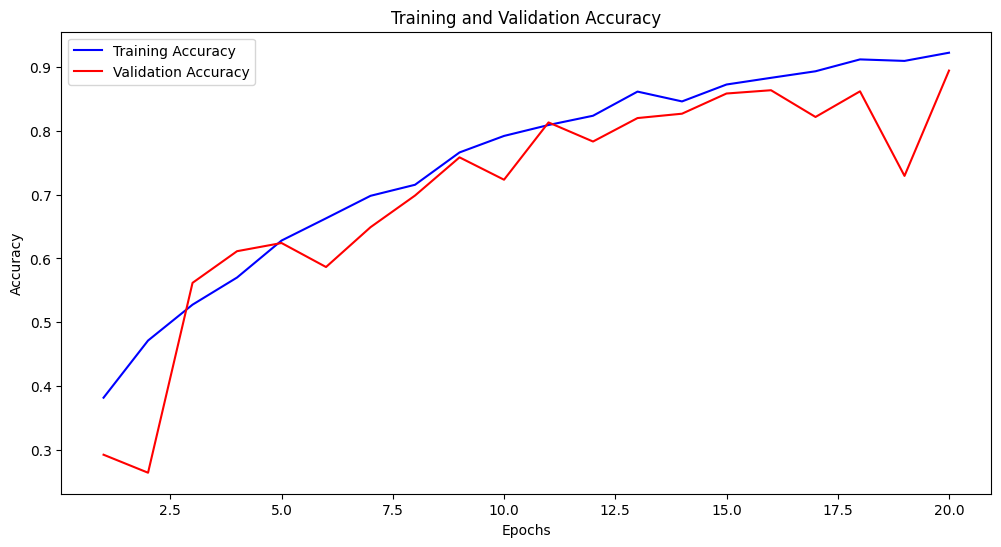

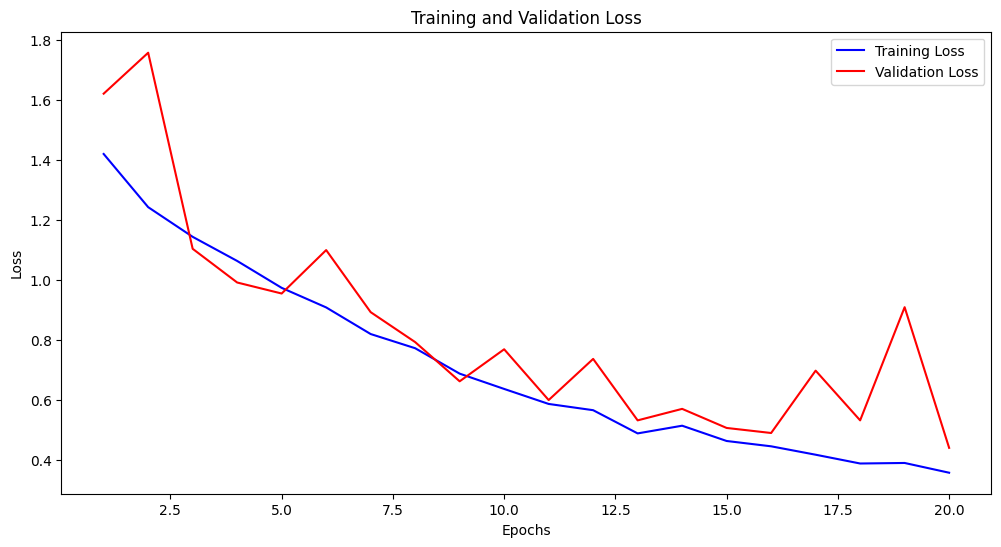

In [11]:
# Main function to train the improved model
def train_model(dataset_dir, output_model_path, img_size=(128, 128), learning_rate=0.001, weight_decay=1e-4):
    """
    Train and save a face recognition model.

    Args:
        dataset_dir (str): Path to dataset directory.
        output_model_path (str): Path to save the trained model.
        img_size (tuple): Target size for resizing images.
        learning_rate (float): Learning rate for the optimizer.
        weight_decay (float): Weight decay (L2 regularization factor).
    """
    # Load dataset
    X, y, label_encoder = load_dataset(dataset_dir, img_size)
    num_classes = len(np.unique(y))

    # Split data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    # Build and train the improved model
    model = build_improved_model(
        input_shape=(img_size[0], img_size[1], 3),
        num_classes=num_classes,
        learning_rate=learning_rate,
        weight_decay=weight_decay
    )
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=25)

    # Extract final accuracy values
    final_train_accuracy = history.history['accuracy'][-1] * 100  # Convert to percentage
    final_val_accuracy = history.history['val_accuracy'][-1] * 100  # Convert to percentage

    # Print training and validation accuracy as percentages
    print(f"Final Training Accuracy: {final_train_accuracy:.2f}%")
    print(f"Final Validation Accuracy: {final_val_accuracy:.2f}%")

    # Save the model and label encoder
    model.save(output_model_path)
    np.save(output_model_path + "_labels.npy", label_encoder.classes_)
    print(f"Model saved at {output_model_path}")

    # Plot training history
    plot_training_history(history)

# Example Usage
dataset_directory = "augmented_dataset"  # Path to dataset
output_model_file = "improved_face_recognition_model.h5"  # Path to save the model

train_model(dataset_directory, output_model_file)


37/37 ━━━━━━━━━━━━━━━━━━━━ 16s 411ms/step
Classification Report:
                  precision    recall  f1-score   support

    Akshay Kumar       0.66      0.50      0.57       328
Amitabh Bachchan       0.63      0.48      0.54       244
         Prabhas       0.44      0.86      0.58       302
           vijay       0.71      0.35      0.47       294

        accuracy                           0.55      1168
       macro avg       0.61      0.55      0.54      1168
    weighted avg       0.61      0.55      0.54      1168



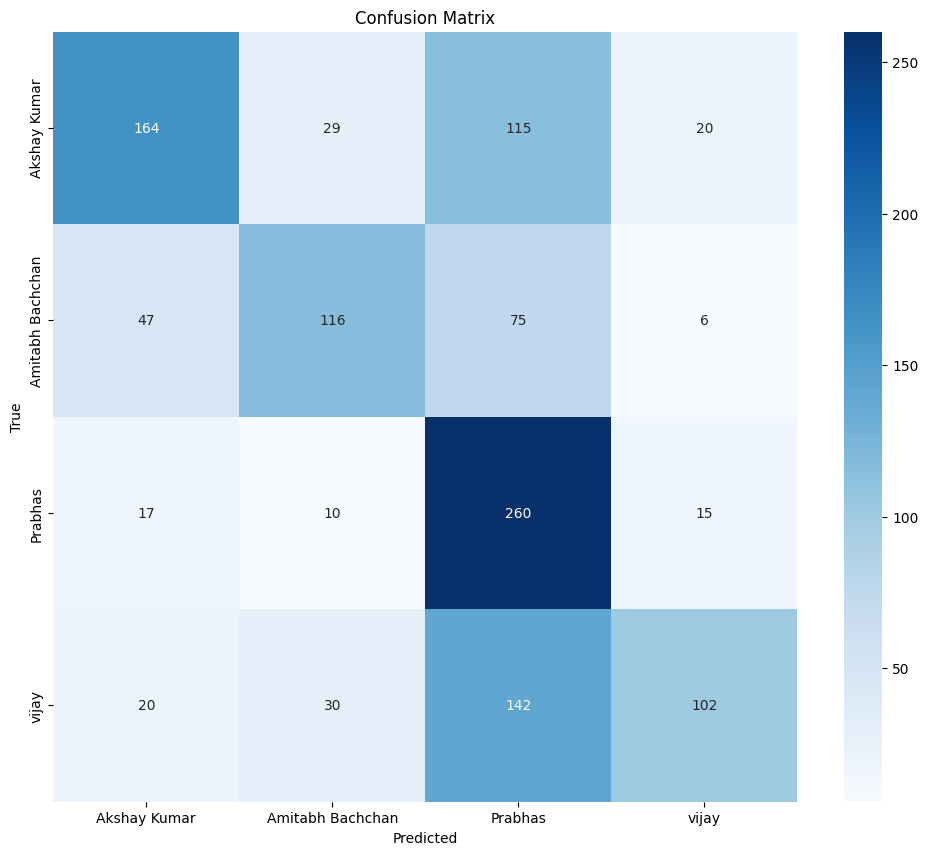

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Predicted label for the image: Amitabh Bachchan


In [49]:
import numpy as np
import cv2
from tensorflow.keras.models import load_model
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Load the trained model and label encoder
def load_model_and_label_encoder(model_path):
    model = load_model(model_path)
    label_encoder_classes = np.load(model_path + "_labels.npy", allow_pickle=True)
    label_encoder = LabelEncoder()
    label_encoder.classes_ = label_encoder_classes
    return model, label_encoder

# Preprocess the image for prediction
def preprocess_image(img_path, target_size=(128, 128)):
    # Load the image with OpenCV
    img = cv2.imread(img_path)
    # Resize the image
    img_resized = cv2.resize(img, target_size)
    # Normalize the image
    img_normalized = img_resized / 255.0
    # Add a batch dimension
    img_expanded = np.expand_dims(img_normalized, axis=0)
    return img_expanded

# Predict the class of an image
def predict_image(model, label_encoder, img_path):
    img_preprocessed = preprocess_image(img_path)
    predictions = model.predict(img_preprocessed)
    predicted_class_idx = np.argmax(predictions, axis=1)
    predicted_class_label = label_encoder.inverse_transform(predicted_class_idx)
    return predicted_class_label[0]

# Evaluate the model with confusion matrix and classification report
def evaluate_model(model, label_encoder, X_val, y_val, class_names):
    y_pred = model.predict(X_val)
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Print classification report
    print("Classification Report:")
    print(classification_report(y_val, y_pred_classes, target_names=class_names))

    # Plot confusion matrix
    cm = confusion_matrix(y_val, y_pred_classes)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Data augmentation and model evaluation
def augment_and_evaluate_model(model, label_encoder, dataset_dir, img_size=(128, 128)):
    # Create an ImageDataGenerator for data augmentation
    datagen = ImageDataGenerator(
        rescale=1./255,  # Normalize images
        rotation_range=20,  # Random rotations
        width_shift_range=0.2,  # Random horizontal shifts
        height_shift_range=0.2,  # Random vertical shifts
        shear_range=0.2,  # Random shears
        zoom_range=0.2,  # Random zoom
        horizontal_flip=True,  # Random horizontal flips
        fill_mode='nearest'  # Filling in new pixels after transformations
    )

    # Load dataset and split into training and validation sets
    X, y, _ = load_dataset(dataset_dir, img_size)
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    # Fit the data generator on the training set
    train_generator = datagen.flow(X_train, y_train, batch_size=32)

    # Evaluate model on validation set using augmented data
    class_names = label_encoder.classes_
    evaluate_model(model, label_encoder, X_val, y_val, class_names)

# Function to load dataset (Ensure you have a proper function to load images and labels)
def load_dataset(dataset_dir, img_size=(128, 128)):
    # Load images from the dataset directory and preprocess them
    X = []  # List to store images
    y = []  # List to store corresponding labels
    labels = []

    class_names = os.listdir(dataset_dir)

    for class_label in class_names:
        class_dir = os.path.join(dataset_dir, class_label)
        if os.path.isdir(class_dir):
            for img_name in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_name)
                img = load_img(img_path, target_size=img_size)
                img_array = img_to_array(img) / 255.0  # Normalize image
                X.append(img_array)
                y.append(class_label)

    X = np.array(X)
    y = np.array(y)

    # Encode labels
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(y)  # Convert labels to numeric values

    return X, y, label_encoder.classes_

# Hyperparameter tuning using different architectures or layers (optional)
def fine_tune_model(model, X_train, y_train, X_val, y_val):
    # Example of modifying the model (e.g., adding more layers, changing learning rate)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

    return model

# Main execution
def main():
    model_path = "/content/improved_face_recognition_model.h5"  # Path to your trained model
    dataset_directory = "/content/augmented_dataset"  # Path to dataset

    # Load the model and label encoder
    model, label_encoder = load_model_and_label_encoder(model_path)

    # Evaluate model with the dataset
    augment_and_evaluate_model(model, label_encoder, dataset_directory)

    # Test on a single image
    img_path = "/content/amit.jpeg"  # Replace with your image path
    predicted_label = predict_image(model, label_encoder, img_path)
    print(f"Predicted label for the image: {predicted_label}")

    # Fine-tuning the model (optional, only if you're interested in retraining)
    # X_train, y_train, X_val, y_val = load_dataset(dataset_directory)  # Make sure dataset is loaded
    # model = fine_tune_model(model, X_train, y_train, X_val, y_val)

if __name__ == "__main__":
    main()
